<h1 align=center><font size = 4>Analysis of Neighbourhoods in Toronto</font></h1>

### Table of Contents

1.  Introduction/Business Problem
2.  Data
3.  Methodology  
4.  Result

### Introduction/Business Problem

At the time when writing this article, COVID-19 has been prevalent across the globe and Canada is not an exception. Especially, Ontario, one of the provinces in Canada, has been taking an approach of locking down the entire province to prevent it from spreading further. To be more precise, Ontario restricts its residents to staying home and only going out for essential reasons such as shopping for groceries. All stores other than essential ones have been closed.

Given this current situation, I chose to investigate community COVID-19 cases per each neighbourhood in Toronto and what types of businesses are popular in that neighbourhood so that we could have an insight into what types of business particularly need to be paid attention in certain neighbourhoods to reduce the spread of a pandemic. 

The city of Toronto defined cases with no reported travel outside of Ontario, no known close contact with a COVID-19 case, and no reported infection acquired in an institutional or healthcare setting as community case of COVID-19. For that cases, I assume that patients are infected after visiting some common places near where they live. 

### Data

The following are datasets obtained for this project: 
* Neighbourhood Profiles: contains a list of 140 neighbourhoods in Toronto and population for each neighbourhood in 2016. 
    https://open.toronto.ca/dataset/neighbourhood-profiles/
* COVID-19 dataset in Toronto: COVID-19 cases in Toronto obtained as of January 19th , 2021
    https://open.toronto.ca/dataset/covid-19-cases-in-toronto/
* FourSquare API: venues nearby each postal codes area in Toronto were pulled.

Each dataset above was imported and transformed. In turn, two datasets, **toneigh** and **venues**, which we will mainly use for further analysis, have been made.  

In [1]:
# Import library
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np 

import json
import geojson as gj
import folium

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

**toneigh** has 140 neighbourhoods in Toronto with attributes: Borough, Latitude, Longitude, number of people infected with COVID19 as community case, population in 2016, and proportion of people infected with COVID19 among the population in the neighbourhood. Notice that population data in 2016 is the most recent one on the Toronto Open Data Portal, https://www.toronto.ca/city-government/data-research-maps/open-data/.
So, in this article, I assumed that there is no change in the population of the neighbourhoods.

In [2]:
# Import dataset
toneigh = pd.read_csv('finaldataset.csv', header=0)
print(toneigh.shape)

toneigh.head() 

(140, 8)


Hood                      Neighbourhood    Borough   Latitude  Longitude  \
0     1             West Humber-Clairville  Etobicoke  43.735649 -79.625844   
1     2  Mount Olive-Silverstone-Jamestown  Etobicoke  43.741149 -79.589238   
2     3       Thistletown-Beaumond Heights  Etobicoke  43.742903 -79.571267   
3     4                    Rexdale-Kipling  Etobicoke  43.719857 -79.570600   
4     5                   Elms-Old Rexdale  Etobicoke  43.723712 -79.548860   

   percentcovid  totalcovidppl  Population, 2016  
0          0.75          249.0             33312  
1          0.95          312.0             32954  
2          0.67           69.0             10360  
3          0.37           39.0             10529  
4          0.48           45.0              9456

**venues** is a dataset of venues within 1km of each neighbourhood which was pulled from FourSquare API. It has 6661 venues and information about neighbourhood in which the venue was placed, neighbourhood location (Latitude and Longitude), venue name, venue location, and venue category.

In [3]:
# Import dataset
venues = pd.read_csv('finalvenues.csv', header=0)
print(venues.shape)

venues.head()

(6661, 7)


Hood   Latitude  Longitude            Venue  Venue Latitude  \
0     1  43.735649 -79.625844      Tim Hortons       43.734656   
1     1  43.735649 -79.625844  Hwy 427 & Finch       43.733811   
2     1  43.735649 -79.625844     Sayona Foods       43.737692   
3     1  43.735649 -79.625844   Malton Variety       43.733146   
4     1  43.735649 -79.625844       On the Run       43.734646   

   Venue Longitude           category  
0       -79.617625      DessertCoffee  
1       -79.627130       Intersection  
2       -79.622984            Grocery  
3       -79.633326  Convenience Store  
4       -79.617632  Convenience Store

### Methodology

In the exploratory data analysis, I found that large number of venues are in old toronto area. In terms of population, the most crowded neighbourhood is Waterfront Communities-The Island in old Toronto and many crowded neighbourhoods are in Scarborough. Neighbourhoods with high percentage of people infected with COVID-19 are in North York area. Most common category of venues in Toronto is Restaurants. Second and third most ones are DessertCoffee which includes coffee shops and dessert stores.

In order to discover whether there are hidden patterns in the datasets presented above, I chose K-means algorithm. K-means algorithm is unsupervised clustering algorithm which partitions data into clusters based on similar features. A cluster refers to a collection of data points aggregated together because of certain similarities. K-means has three assumptions regarding clusters:
* Features within a cluster have equal variance
* Features within a cluster are independent of each other 
* Each cluster has roughly equal number of observations

To determine the optimal number of clusters for K-means, elbow method has been used and four clusters, elbow of the curve, are chosen. 

#### Exploratory Data Analysis

In [4]:
# to see the max, min, mean, and standard deviation of attributes
toneigh[['percentcovid','totalcovidppl', 'Population, 2016']].describe()

percentcovid  totalcovidppl  Population, 2016
count    140.000000     140.000000        140.000000
mean       0.290929      59.435714      19511.221429
std        0.203087      57.953617      10033.589222
min        0.000000       0.000000       6577.000000
25%        0.147500      20.000000      12019.500000
50%        0.230000      41.500000      16749.500000
75%        0.400000      80.000000      23854.500000
max        0.950000     312.000000      65913.000000

In [5]:
# import geojson to map boundaries of neighbourhoods in Toronto
with open('Neighbourhoods.geojson') as f:
    togj = gj.load(f)

In [6]:
# one hot encoding
onehot = pd.get_dummies(venues[['category']], prefix="", prefix_sep="")
numvenues = pd.DataFrame(venues.groupby('Hood').size().reset_index(name = "numvenues").set_index("Hood"))

# insert columns of Hood, number of venues, and percentage of people infected with COVID-19
onehot.insert(0, 'Hood', venues['Hood'])

onehot = round(onehot.groupby(['Hood']).mean(),2).reset_index()

onehot = onehot.join(numvenues, on = 'Hood')
onehot.insert(1, 'percentcovid', toneigh['percentcovid'])
onehot = onehot[['Hood', 'numvenues', 'percentcovid', 'ATM', 'Animal Shelter', 'ArtsMuseum',
       'Building', 'Cemetery', 'Church', 'Construction & Landscaping',
       'Convenience Store', 'DessertCoffee', 'Entertainment', 'Farm',
       'Gas Station', 'Grocery', 'Hotel', 'Housing Development',
       'IndoorGymSprots', 'Intersection', 'Library', 'LiquorstoresBar',
       'Medical', 'Neighborhood', 'Office', 'ParkOutdoorSports',
       'PersonalCare', 'PersonalService', 'PhotoFilmMusicStudio',
       'RentalService', 'Restaurants', 'Road', 'ScenicSpot', 'SchoolEducation',
       'ShipMail', 'ShoppingStores', 'Smoke', 'TrainMetroBus']]

print(onehot.shape)

onehot.head(1)

(140, 38)


Hood  numvenues  percentcovid  ATM  Animal Shelter  ArtsMuseum  Building  \
0     1          7          0.75  0.0             0.0         0.0       0.0   

   Cemetery  Church  Construction & Landscaping  Convenience Store  \
0       0.0     0.0                         0.0               0.29   

   DessertCoffee  Entertainment  Farm  Gas Station  Grocery  Hotel  \
0           0.14            0.0   0.0          0.0     0.29    0.0   

   Housing Development  IndoorGymSprots  Intersection  Library  \
0                  0.0              0.0          0.14      0.0   

   LiquorstoresBar  Medical  Neighborhood  Office  ParkOutdoorSports  \
0              0.0      0.0           0.0     0.0               0.14   

   PersonalCare  PersonalService  PhotoFilmMusicStudio  RentalService  \
0           0.0              0.0                   0.0            0.0   

   Restaurants  Road  ScenicSpot  SchoolEducation  ShipMail  ShoppingStores  \
0          0.0   0.0         0.0              0.0       0.0             0.0   

   Smoke  TrainMetroBus  
0    0.0            0.0

In [7]:
# to see the max, min, mean, and standard deviation of attributes
onehot.iloc[:,1:].describe()

numvenues  percentcovid         ATM  Animal Shelter  ArtsMuseum  \
count  140.000000    140.000000  140.000000      140.000000  140.000000   
mean    47.578571      0.290929    0.003500        0.000071    0.005429   
std     30.637605      0.203087    0.012051        0.000845    0.015332   
min      5.000000      0.000000    0.000000        0.000000    0.000000   
25%     24.000000      0.147500    0.000000        0.000000    0.000000   
50%     36.000000      0.230000    0.000000        0.000000    0.000000   
75%     70.250000      0.400000    0.000000        0.000000    0.000000   
max    100.000000      0.950000    0.070000        0.010000    0.100000   

         Building    Cemetery      Church  Construction & Landscaping  \
count  140.000000  140.000000  140.000000                  140.000000   
mean     0.000357    0.000071    0.000143                    0.004571   
std      0.002519    0.000845    0.001191                    0.016332   
min      0.000000    0.000000    0.000000                    0.000000   
25%      0.000000    0.000000    0.000000                    0.000000   
50%      0.000000    0.000000    0.000000                    0.000000   
75%      0.000000    0.000000    0.000000                    0.000000   
max      0.020000    0.010000    0.010000                    0.140000   

       Convenience Store  DessertCoffee  Entertainment        Farm  \
count         140.000000     140.000000     140.000000  140.000000   
mean            0.015071       0.121857       0.004643    0.000071   
std             0.033832       0.058255       0.010485    0.000845   
min             0.000000       0.000000       0.000000    0.000000   
25%             0.000000       0.090000       0.000000    0.000000   
50%             0.000000       0.120000       0.000000    0.000000   
75%             0.020000       0.160000       0.000000    0.000000   
max             0.290000       0.240000       0.060000    0.010000   

       Gas Station     Grocery       Hotel  Housing Development  \
count   140.000000  140.000000  140.000000           140.000000   
mean      0.014643    0.074643    0.005714             0.000143   
std       0.024943    0.048062    0.014401             0.001690   
min       0.000000    0.000000    0.000000             0.000000   
25%       0.000000    0.047500    0.000000             0.000000   
50%       0.000000    0.070000    0.000000             0.000000   
75%       0.020000    0.100000    0.000000             0.000000   
max       0.130000    0.290000    0.080000             0.020000   

       IndoorGymSprots  Intersection     Library  LiquorstoresBar     Medical  \
count       140.000000    140.000000  140.000000       140.000000  140.000000   
mean          0.035000      0.009929    0.000286         0.059000    0.037500   
std           0.035411      0.022296    0.002058         0.054089    0.040909   
min           0.000000      0.000000    0.000000         0.000000    0.000000   
25%           0.000000      0.000000    0.000000         0.015000    0.000000   
50%           0.030000      0.000000    0.000000         0.050000    0.020000   
75%           0.050000      0.000000    0.000000         0.090000    0.060000   
max           0.200000      0.140000    0.020000         0.300000    0.160000   

       Neighborhood      Office  ParkOutdoorSports  PersonalCare  \
count    140.000000  140.000000         140.000000    140.000000   
mean       0.001929    0.030571           0.066714      0.018357   
std        0.013024    0.033517           0.080960      0.025064   
min        0.000000    0.000000           0.000000      0.000000   
25%        0.000000    0.000000           0.020000      0.000000   
50%        0.000000    0.025000           0.040000      0.000000   
75%        0.000000    0.050000           0.090000      0.030000   
max        0.140000    0.170000           0.560000      0.100000   

       PersonalService  PhotoFilmMusicStudio  RentalService  Restaurants  \
count       140.0000

In [8]:
# generate choropleth map 
venue_map = folium.Map(location=[43.6532, -79.3832], zoom_start=10)
threshold_scale = np.linspace(onehot['numvenues'].min(), onehot['numvenues'].max(), 3, dtype=float)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1 

venue_map.choropleth(
    geo_data=togj,
    data=onehot,
    columns=['Hood', 'numvenues'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Number of venues in the Neighbourhoods in Toronto',
    reset=True
)

venue_map

In [9]:
# to see which borough has large number of venues
toneigh.loc[onehot.loc[:,'numvenues'] > 53, 'Borough'].mode()

0    Old Toronto
dtype: object

In [10]:
# to see which borough has the neighbourhood with the largest number of venues
toneigh.loc[onehot.loc[:,'numvenues']==max(onehot.loc[:,'numvenues']), 'Borough'].mode()

0    Old Toronto
dtype: object

In [11]:
# generate choropleth map 
pop_map = folium.Map(location=[43.6532, -79.3832], zoom_start=10)
threshold_scale = np.linspace(toneigh['Population, 2016'].min(), toneigh['Population, 2016'].max(), 3, dtype=float)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1 

pop_map.choropleth(
    geo_data=togj,
    data=toneigh,
    columns=['Hood', 'Population, 2016'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Populations in the Neighbourhoods in Toronto',
    reset=True
)

# display map
pop_map

In [12]:
# to see which borough has large population
toneigh.loc[toneigh.loc[:,'Population, 2016'] > 36245, 'Borough'].mode()

0    Scarborough
dtype: object

In [13]:
# to see which borough has the neighbourhood with the largest population
toneigh.loc[toneigh.loc[:,'Population, 2016']==max(toneigh.loc[:,'Population, 2016']), 'Neighbourhood'].mode()

0    Waterfront Communities-The Island
dtype: object

In [14]:
# generate choropleth map
covid_map = folium.Map(location=[43.6532, -79.3832], zoom_start=10)
threshold_scale = np.linspace(toneigh['percentcovid'].min(), toneigh['percentcovid'].max(), 3, dtype=float)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 0.01 

covid_map.choropleth(
    geo_data=togj,
    data=toneigh,
    columns=['Hood', 'percentcovid'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Percentage of people infected with Covid19 in the Neighbourhoods in Toronto',
    reset=True
)

# display map
covid_map

In [15]:
# to see which borough has large community covid19 infection rate
toneigh.loc[toneigh.loc[:,'percentcovid'] > 0.5, 'Borough'].mode()

0    North York
dtype: object

In [16]:
# function to return common venues per neighbourhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Hood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted[['Hood']] = toneigh[['Hood']]

for ind in np.arange(onehot.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(onehot.iloc[ind, :], num_top_venues)

print(venues_sorted.shape)

venues_sorted.head(10)

(140, 11)


Hood 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     1               Grocery     Convenience Store         DessertCoffee   
1     2           Restaurants        ShoppingStores               Grocery   
2     3           Restaurants        ShoppingStores         DessertCoffee   
3     4           Restaurants       PersonalService        ShoppingStores   
4     5        ShoppingStores           Restaurants         DessertCoffee   
5     6           Restaurants        ShoppingStores         DessertCoffee   
6     7               Grocery           Restaurants        ShoppingStores   
7     8           Restaurants         DessertCoffee        ShoppingStores   
8     9               Medical        ShoppingStores         DessertCoffee   
9    10         DessertCoffee     ParkOutdoorSports       PersonalService   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     ParkOutdoorSports          Intersection         Entertainment   
1       LiquorstoresBar               Medical                Office   
2     ParkOutdoorSports         TrainMetroBus               Grocery   
3       IndoorGymSprots         DessertCoffee          PersonalCare   
4               Grocery           Gas Station               Medical   
5               Grocery       LiquorstoresBar         TrainMetroBus   
6         DessertCoffee         TrainMetroBus     ParkOutdoorSports   
7               Grocery               Medical           Gas Station   
8               Grocery     ParkOutdoorSports           Restaurants   
9           Restaurants       LiquorstoresBar               Medical   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0   Housing Development                 Hotel           Gas Station   
1         TrainMetroBus              ShipMail       PersonalService   
2                Office       PersonalService       IndoorGymSprots   
3           Gas Station               Medical                Office   
4     ParkOutdoorSports     Convenience Store         TrainMetroBus   
5               Medical                Office          PersonalCare   
6          Intersection               Medical                   ATM   
7       IndoorGymSprots     ParkOutdoorSports                 Hotel   
8                Office         TrainMetroBus          PersonalCare   
9               Grocery        ShoppingStores              Cemetery   

  10th Most Common Venue  
0                   Farm  
1               Building  
2                 Church  
3      Convenience Store  
4                   Farm  
5           Intersection  
6   PhotoFilmMusicStudio  
7                   Farm  
8      Convenience Store  
9                 Church

In [18]:
# to see what venues are popular in Toronto
venues_sorted.iloc[:, 1:].mode()

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Restaurants         DessertCoffee         DessertCoffee   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        ShoppingStores               Grocery     ParkOutdoorSports   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       IndoorGymSprots               Medical       IndoorGymSprots   

  10th Most Common Venue  
0                   Farm

### K-means

In [19]:
# feature set
X = onehot.drop(['Hood', 'numvenues'], axis=1)

#### Optimal K: Elbow Method

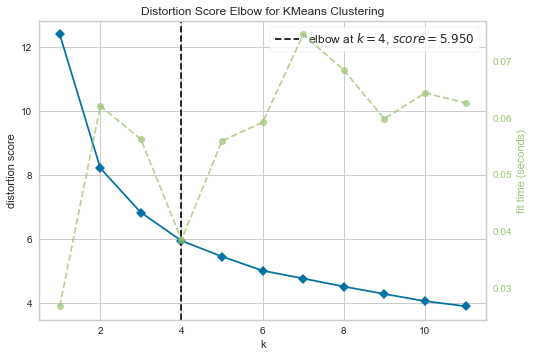

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,12))
visualizer.fit(X)        
visualizer.show()        

#### K means

In [21]:
# Apply k-means algorithm
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [22]:
venues_sorted.insert(1, 'labels', kmeans.labels_)
venues_sorted.insert(2, 'percentcovid', toneigh['percentcovid'])
venues_sorted.insert(3,'Neighbourhood', toneigh['Neighbourhood'])
venues_sorted.insert(4,'Borough', toneigh['Borough'])
venues_sorted.insert(5,'Population, 2016', toneigh['Population, 2016'])
venues_sorted.insert(6,'numvenues', onehot['numvenues'])

### Result

Map below shows how the data were partitioned into clusters. Cluster 0 includes 64 neighbourhoods and most of them are convenient for public transit, subway and bus. Because of the public transit, these areas are urbanized so that there are a lot of restaurants, coffee and dessert shops, and shopping centres. In these neighbourhoods, percentage of people infected with Covid-19 is 0.15%. Cluster 1 has 34 neighbourhoods where are a bit far from public transit but have similar venues as cluster 0: restaurants, shopping stores, grocery stores,and dessert and coffee shops. Covid-19 infection rate is 0.3% on average. 25 neighbourhoods are in Cluster 2. Park and outside sports are popular in these neighbourhoods. In terms of Covid-19 infection rate on average, these neighbourhoods have second lowest rate with 0.19%. Cluster 3 has 17 neighbourhoods and these neighbour hoods have the highest people infected with Covid-19, 0.71%. In these area, venues such as doctor's office and pharmacy are popular. 

#### Map

In [23]:
# generate choropleth map
clutered_map = folium.Map(location=[43.6532, -79.3832], zoom_start=10)
threshold_scale = [0, 1, 2, 3, 4]
threshold_scale[-1] = threshold_scale[-1]+0.01

clutered_map.choropleth(
    geo_data=togj,
    data=venues_sorted,
    columns=['Hood', 'labels'],
    key_on='feature.properties.AREA_LONG_CODE',
    threshold_scale=threshold_scale,
    fill_color='Paired', 
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Cluster',
    reset=True
)

# display map
clutered_map

In [24]:
v = ['1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue']

In [25]:
# create new dataframe to see variance of attributes in each clusters (checking assumptions of k-means)
tildeX = X
tildeX.insert(0, 'labels', kmeans.labels_)

#### Cluster 0

In [26]:
# number of neighbourhoods in cluster 0
venues_sorted.loc[venues_sorted['labels']==0.0, :].shape[0]

64

In [27]:
# standard deviations of the attributes in cluster 0
tildeX.loc[venues_sorted['labels']==0.0, :].std()

labels                        0.000000
percentcovid                  0.080937
ATM                           0.003934
Animal Shelter                0.001250
ArtsMuseum                    0.015482
Building                      0.002777
Cemetery                      0.001250
Church                        0.001754
Construction & Landscaping    0.010117
Convenience Store             0.020461
DessertCoffee                 0.049819
Entertainment                 0.011194
Farm                          0.001250
Gas Station                   0.013093
Grocery                       0.036899
Hotel                         0.012574
Housing Development           0.000000
IndoorGymSprots               0.024563
Intersection                  0.013787
Library                       0.002777
LiquorstoresBar               0.055016
Medical                       0.026992
Neighborhood                  0.002705
Office                        0.023401
ParkOutdoorSports             0.030406
PersonalCare             

In [28]:
# to see what venues are popular in cluster 0
venues_sorted.loc[venues_sorted['labels']==0.0, v].mode()

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Restaurants         DessertCoffee         DessertCoffee   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        ShoppingStores               Grocery       IndoorGymSprots   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       IndoorGymSprots     ParkOutdoorSports     ParkOutdoorSports   

  10th Most Common Venue  
0            Gas Station

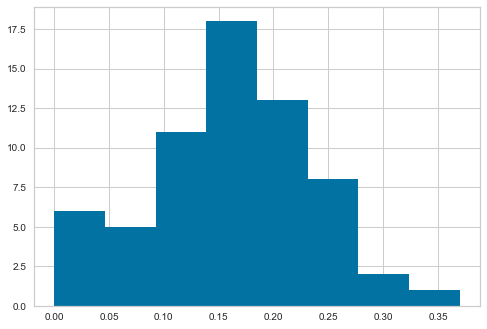

In [29]:
# distribution of community covid-19 infection rate in cluster 0 
plt.hist(venues_sorted.loc[venues_sorted['labels']==0.0, 'percentcovid'], bins = 8)
plt.show()

In [30]:
# mean of community covid-19 infection rate in cluster 0 
venues_sorted.loc[venues_sorted['labels']==0.0, 'percentcovid'].mean()

0.15984375000000006

#### Cluster 1

In [31]:
# number of neighbourhoods in cluster 1
venues_sorted.loc[venues_sorted['labels']==1.0, :].shape[0]

34

In [32]:
# standard deviations of the attributes in cluster 1
tildeX.loc[venues_sorted['labels']==1.0, :].std()

labels                        0.000000
percentcovid                  0.080900
ATM                           0.016912
Animal Shelter                0.000000
ArtsMuseum                    0.017150
Building                      0.000000
Cemetery                      0.000000
Church                        0.000000
Construction & Landscaping    0.026407
Convenience Store             0.033255
DessertCoffee                 0.049981
Entertainment                 0.009539
Farm                          0.000000
Gas Station                   0.032801
Grocery                       0.056212
Hotel                         0.008714
Housing Development           0.000000
IndoorGymSprots               0.030771
Intersection                  0.019814
Library                       0.001715
LiquorstoresBar               0.035500
Medical                       0.043353
Neighborhood                  0.024150
Office                        0.031118
ParkOutdoorSports             0.042300
PersonalCare             

In [33]:
# to see what venues are popular in cluster 1
venues_sorted.loc[venues_sorted['labels']==1.0, v].mode()

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Restaurants        ShoppingStores               Grocery   
1                   NaN                   NaN                   NaN   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         DessertCoffee       IndoorGymSprots       LiquorstoresBar   
1                   NaN                   NaN          PersonalCare   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0           Gas Station               Medical               Medical   
1                   NaN                   NaN                   NaN   

  10th Most Common Venue  
0                   Farm  
1                    NaN

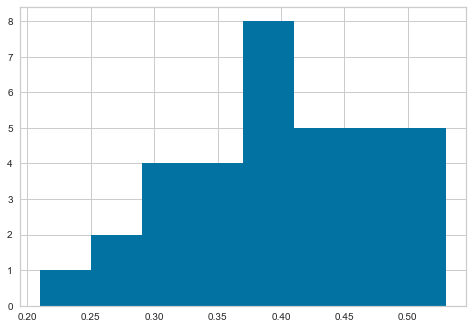

In [34]:
# distribution of community covid-19 infection rate in cluster 1
plt.hist(venues_sorted.loc[venues_sorted['labels']==1.0, 'percentcovid'], bins = 8)
plt.show()

In [35]:
# mean of community covid-19 infection rate in cluster 1
venues_sorted.loc[venues_sorted['labels']==1.0, 'percentcovid'].mean()

0.39647058823529413

#### Cluster 2

In [36]:
# number of neighbourhoods in cluster 2
venues_sorted.loc[venues_sorted['labels']==2.0, :].shape[0]

25

In [37]:
# standard deviations of the attributes in cluster 2
tildeX.loc[venues_sorted['labels']==2.0, :].std()

labels                        0.000000
percentcovid                  0.099791
ATM                           0.012275
Animal Shelter                0.000000
ArtsMuseum                    0.016330
Building                      0.004000
Cemetery                      0.000000
Church                        0.000000
Construction & Landscaping    0.011944
Convenience Store             0.016703
DessertCoffee                 0.056125
Entertainment                 0.000000
Farm                          0.000000
Gas Station                   0.029597
Grocery                       0.049440
Hotel                         0.021733
Housing Development           0.000000
IndoorGymSprots               0.055528
Intersection                  0.029229
Library                       0.000000
LiquorstoresBar               0.060888
Medical                       0.048707
Neighborhood                  0.012000
Office                        0.050751
ParkOutdoorSports             0.124704
PersonalCare             

In [38]:
# to see what venues are popular in cluster 2
venues_sorted.loc[venues_sorted['labels']==2.0, v].mode()

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Restaurants     ParkOutdoorSports         DessertCoffee   
1                   NaN        ShoppingStores                   NaN   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        ShoppingStores               Grocery       LiquorstoresBar   
1                   NaN                   NaN         TrainMetroBus   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       IndoorGymSprots               Medical           Gas Station   
1                   NaN                   NaN                   NaN   

  10th Most Common Venue  
0                   Farm  
1                    NaN

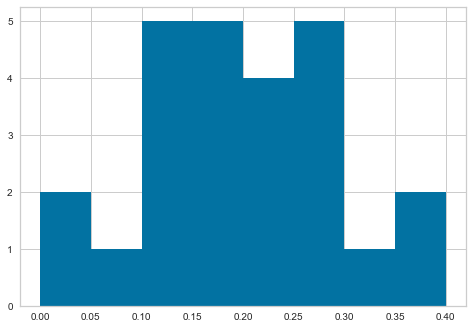

In [39]:
# distribution of community covid-19 infection rate in cluster 2
plt.hist(venues_sorted.loc[venues_sorted['labels']==2.0, 'percentcovid'], bins = 8)
plt.show()

In [40]:
# mean of community covid-19 infection rate in cluster 2
venues_sorted.loc[venues_sorted['labels']==2.0, 'percentcovid'].mean()

0.198

#### Cluster 3

In [41]:
# number of neighbourhoods in cluster 3
venues_sorted.loc[venues_sorted['labels']==3.0, :].shape[0]

17

In [42]:
# standard deviations of the attributes in cluster 3
tildeX.loc[venues_sorted['labels']==3.0, :].std()

labels                        0.000000
percentcovid                  0.107645
ATM                           0.017636
Animal Shelter                0.000000
ArtsMuseum                    0.000000
Building                      0.000000
Cemetery                      0.000000
Church                        0.000000
Construction & Landscaping    0.015049
Convenience Store             0.070157
DessertCoffee                 0.041043
Entertainment                 0.014552
Farm                          0.000000
Gas Station                   0.027400
Grocery                       0.063292
Hotel                         0.016869
Housing Development           0.004851
IndoorGymSprots               0.025029
Intersection                  0.035011
Library                       0.000000
LiquorstoresBar               0.036552
Medical                       0.043293
Neighborhood                  0.000000
Office                        0.033519
ParkOutdoorSports             0.061315
PersonalCare             

In [43]:
# to see what venues are popular in cluster 3
venues_sorted.loc[venues_sorted['labels']==3.0, v].mode()

1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Restaurants        ShoppingStores         DessertCoffee   
1                   NaN                   NaN                   NaN   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0               Grocery               Medical           Gas Station   
1     ParkOutdoorSports         TrainMetroBus                   NaN   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Office       LiquorstoresBar       IndoorGymSprots   
1                   NaN                   NaN                   NaN   

  10th Most Common Venue  
0      Convenience Store  
1                    NaN

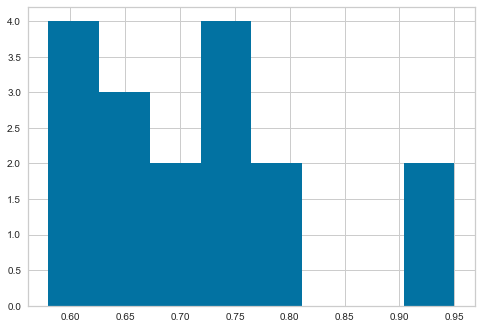

In [44]:
# distribution of community covid-19 infection rate in cluster 3
plt.hist(venues_sorted.loc[venues_sorted['labels']==3.0, 'percentcovid'], bins = 8)
plt.show()

In [45]:
# mean of community covid-19 infection rate in cluster 3
venues_sorted.loc[venues_sorted['labels']==3.0, 'percentcovid'].mean()

0.71

### Conclusion

COVID-19 has been prevalent across Toronto. Among COVID infection cases in Toronto, 28.3% of the cases are revealed that source of infection is community. So, I investigated whether there are hidden patterns in community Covid infection rate and neighbourhoods to reduce the spread of a pandemic.

Using K-means clustering algorithm, we found that neighbourhoods with large number of doctor's office and pharmacy have high community covid infection rates.  